In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from pyproj import Transformer
import matplotlib.pyplot as plt


## This notebook uses census shape files for the DMV counties and block groups to subset block groups of interest for ML pipeline

The output is a shapefile `SELECTED_DMV_BG` with only the block groups I want to use 

### Read shape files for DMV counties and block groups

In [2]:
all_counties_gdf = gpd.read_file("./data/shapes/tl_2020_us_county")

dmv_counties_gdf = all_counties_gdf[all_counties_gdf["STATEFP"].isin(["11","24","51"])] # filter to dmv

<Axes: >

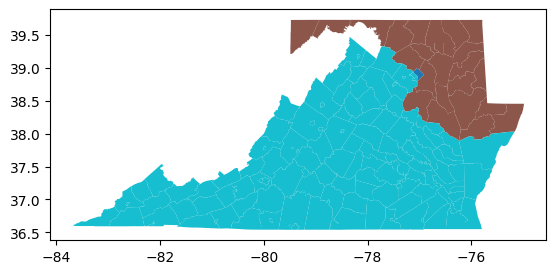

In [3]:
dmv_counties_gdf.plot(column="STATEFP")

In [4]:
va_bg_gdf = gpd.read_file("./data/shapes/tl_2010_51_bg10")
md_bg_gdf = gpd.read_file("./data/shapes/tl_2010_24_bg10")
dc_bg_gdf = gpd.read_file("./data/shapes/tl_2010_11_bg10")

dmv_bg_gdf = pd.concat([va_bg_gdf, md_bg_gdf, dc_bg_gdf],ignore_index=True)

<Axes: >

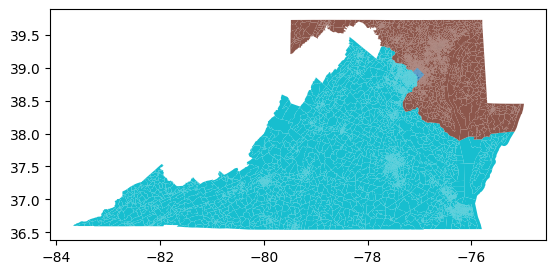

In [53]:
dmv_bg_gdf.plot(column="STATEFP10")

### Filter by radius

In [5]:
dmv_bg_gdf = dmv_bg_gdf.to_crs(epsg=3857) # change crs to work in meters

In [6]:
dc_center = Point(-77.0369, 38.9072) # set center of DC

transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True) # transform to work with meters
dc_center_projected = Point(transformer.transform(dc_center.x, dc_center.y))


In [7]:
radius_meters = dc_center_projected.buffer(48000) # get a radius of 32,000m (~ 20 miles)
dmv_bg_radius_gdf = dmv_bg_gdf[dmv_bg_gdf.intersects(radius_meters)] # filter df


<Axes: >

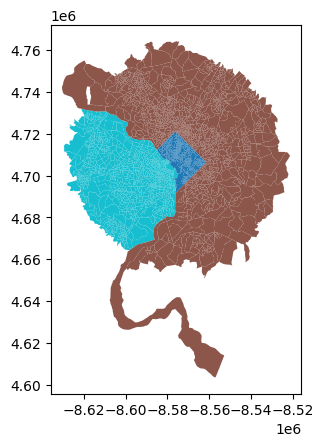

In [8]:
dmv_bg_radius_gdf.plot(column="STATEFP10")

### Filter by DC Metropolitan Statistical Area 

The DC MSA is contains more counties than I select here. I focus on just the counties directly bordering DC

<Axes: >

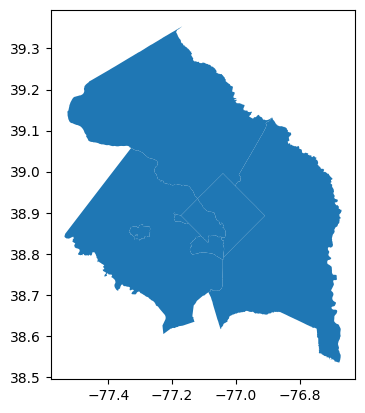

In [39]:
# get just the county shapes that border DC

county_names = ["District of Columbia", "Arlington", "Falls Church", "Alexandria", "Fairfax",
                 "Prince George's", "Montgomery"]

dmv_counties_subset_gdf = dmv_counties_gdf[dmv_counties_gdf["NAME"].isin(county_names)]
dmv_counties_subset_gdf = dmv_counties_subset_gdf.drop(28, axis=0) # drop extra Montgomery county in VA
dmv_counties_subset_gdf.plot()

<Axes: >

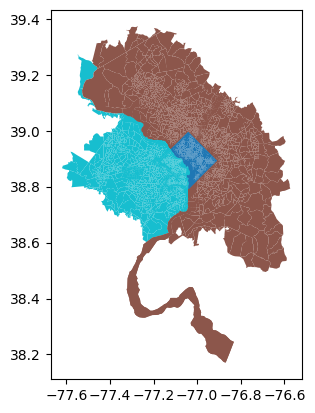

In [40]:
dmv_bg_gdf = dmv_bg_gdf.to_crs("4269") # reset crs to match counties

# filter block groups to those only intersecting the counties
intersecting_bg = gpd.sjoin(dmv_bg_gdf, dmv_counties_subset_gdf, how = "inner", predicate="intersects")

intersecting_bg.plot(column="STATEFP10") # note that block groups just outside the counties are kept
                                         # we want to fix this

In [41]:
# use a tiny buffer to get block groups fully contained within the counties 

buffered_counties = dmv_counties_subset_gdf.copy() 
buffered_counties['geometry'] = buffered_counties.geometry.buffer(0.001) 

# Perform the spatial join
intersecting_bg = gpd.sjoin(dmv_bg_gdf, buffered_counties, how="inner", predicate="intersects")

# Filter the block groups that are fully inside the buffered county boundaries
intersecting_bg = intersecting_bg[intersecting_bg.geometry.within(buffered_counties.unary_union)]

/var/folders/5c/d2k1t24s5zl213152tpfh6nh0000gn/T/ipykernel_49315/2257355300.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_counties['geometry'] = buffered_counties.geometry.buffer(0.001)
/var/folders/5c/d2k1t24s5zl213152tpfh6nh0000gn/T/ipykernel_49315/2257355300.py:10: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  intersecting_bg = intersecting_bg[intersecting_bg.geometry.within(buffered_counties.unary_union)]


In [43]:
intersecting_bg = intersecting_bg.drop_duplicates(subset=["GEOID10"]) # drop duplicate block groups

<Axes: >

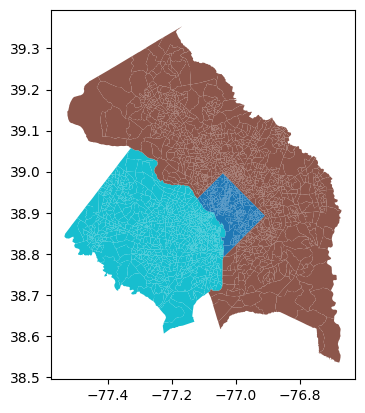

In [44]:
intersecting_bg.plot(column="STATEFP10")

In [47]:
intersecting_bg

,STATEFP10,COUNTYFP10,TRACTCE10,BLKGRPCE10,GEOID10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,...,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON
2645,51,600,300100,4,516003001004,Block Group 4,G5030,S,495782,0,...,C7,G4020,548,47900,47894,F,16162728,84155,+38.8531833,-077.2990252
2646,51,600,300100,2,516003001002,Block Group 2,G5030,S,920031,0,...,H1,G4020,548,47900,47894,A,1012739503,40071739,+38.8295203,-077.2732524
2647,51,600,300100,1,516003001001,Block Group 1,G5030,S,1132102,1296,...,H1,G4020,548,47900,47894,A,1012739503,40071739,+38.8295203,-077.2732524
2648,51,600,300300,1,516003003001,Block Group 1,G5030,S,1481082,20501,...,H1,G4020,548,47900,47894,A,1012739503,40071739,+38.8295203,-077.2732524
2656,51,600,300400,1,516003004001,Block Group 1,G5030,S,780354,0,...,H1,G4020,548,47900,47894,A,1012739503,40071739,+38.8295203,-077.2732524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9703,11,001,001600,4,110010016004,Block Group 4,G5030,S,1623544,35617,...,H6,G4020,548,47900,47894,F,158316124,18709762,+38.9042474,-077.0165167
9704,11,001,000300,4,110010003004,Block Group 4,G5030,S,163765,0,...,H6,G4020,548,47900,47894,F,158316124,18709762,+38.9042474,-077.0165167
9705,11,001,000300,1,110010003001,Block Group 1,G5030,S,250102,0,...,H6,G4020,548,47900,47894,F,158316124,18709762,+38.9042474,-077.0165167
9706,11,001,010600,1,110010106001,Block Group 1,G5030,S,77979,0,...,H6,G4020,548,47900,47894,F,158316124,18709762,+38.9042474,-077.0165167


In [46]:
intersecting_bg.to_file("./data/shapes/SELECTED_DMV_BG/SELECTED_DMV_BG.shp",index=False) # save!

/var/folders/5c/d2k1t24s5zl213152tpfh6nh0000gn/T/ipykernel_49315/2552047666.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  intersecting_bg.to_file("./data/shapes/SELECTED_DMV_BG/SELECTED_DMV_BG.shp",index=False) # save!
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(
